In [1]:
import pandas as pd

In [12]:
import numpy as np

In [208]:
import matplotlib.pyplot as plt

In [58]:
keywords = pd.read_csv('keywords.csv')

In [59]:
keywords.head()

,keyword,shows
0,вк,64292779
1,одноклассники,63810309
2,порно,41747114
3,ютуб,39995567
4,вконтакте,21014195


## 1. Гео-классификатор

In [7]:
geo_data = {
    'Центр': ['москва', 'тула', 'ярославль'],
    'Северо-Запад': ['петербург', 'псков', 'мурманск'],
    'Дальний Восток': ['владивосток', 'сахалин', 'хабаровск']
}

In [50]:
def get_geo_for_row(row):
    for geo in geo_data.keys():
        for zone in geo_data[geo]:
            if zone in row.keyword:
                return geo
    return np.NaN

In [60]:
keywords['region'] = keywords.apply(get_geo_for_row, axis=1)

In [72]:
keywords[(keywords.region == 'Северо-Запад') & (keywords.keyword.str.contains('порно'))].head()

,keyword,shows,region
73816,псковское порно,4895,Северо-Запад


## 2. Классифицируем фильмы

In [76]:
ratings = pd.read_csv('Python-6_2018-12-13/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [77]:
def get_movie_class(row):
    if (row.rating > 2):
        if (row.rating > 4.5):
            return 'hight'
        return 'medium'
    return 'low'

In [78]:
ratings['class'] = ratings.apply(get_movie_class, axis=1)

In [79]:
ratings.head()

,userId,movieId,rating,timestamp,class
0,1,31,2.5,1260759144,medium
1,1,1029,3.0,1260759179,medium
2,1,1061,3.0,1260759182,medium
3,1,1129,2.0,1260759185,low
4,1,1172,4.0,1260759205,medium


## 3. Среднее значение Lifetime киноманов

In [119]:
sinemafils = ratings[ratings.userId.isin(ratings.groupby('userId').count()[ratings.groupby('userId').count().movieId > 100].reset_index()['userId'].tolist())]

In [130]:
sinemafils.groupby('userId')['timestamp'].agg(['min', 'max']).head()

,min,max
userId,,
4,949778714,949982274
8,1154389340,1154474527
15,997937239,1469330735
17,1127468587,1127476640
19,855190091,855195373


In [151]:
def get_lifetime_in_sec(row):
    return row['max'] - row['min']

In [152]:
sinemafils.groupby('userId')['timestamp'].agg(['min', 'max']).apply(get_lifetime_in_sec, axis=1).mean() / (24 * 60 * 60)

463.8947621482917

## 4. "Раньше снимали настоящее кино, не то что сейчас"

In [177]:
years = range(1950, 2010)

In [193]:
movies = pd.read_csv('Python-6_2018-12-13/ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [189]:
def production_year(row):
    for year in years:
        if str(year) in row['title']:
            return year
    return np.NaN

In [194]:
movies['years'] = movies.apply(production_year, axis=1)

In [202]:
movies[movies['title'].str.contains('\(') == False]

,movieId,title,genres,years
9017,143410,Hyena Road,(no genres listed),NaN
9063,151307,The Lovers and the Despot,(no genres listed),NaN
9118,162376,Stranger Things,Drama,NaN
9124,164979,"Women of '69, Unboxed",Documentary,NaN


In [222]:
rating_by_year = ratings.merge(movies, how = 'left', on = 'movieId').groupby('years')['rating'].mean().sort_values(ascending=False)

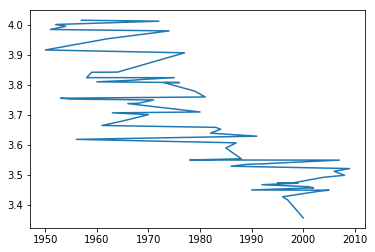

In [224]:
plt.plot(rating_by_year)